<a href="https://colab.research.google.com/github/matheesha/PhishLexURL2021/blob/main/Phishing_LSTM_keras2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import sequence
from prettytable import PrettyTable
import tensorflow as tf

In [3]:
# Some high level parameters:
show_top_n = 20
random_seed = 16

# Setting the random seed so that the code is repeatable.
np.random.seed(random_seed)

In [4]:
# Loading the current combined online-valid dataset.
# Use the dataset_downloader.py to download the current Phishtank online-valid.csv and update the combined dataset.
print("Phishing Dataset")
phishing_df = pd.read_csv('/content/drive/MyDrive/DeepLearning_Phishing/phishing_urls.csv', index_col = False)
phishing_df

print("Benign Dataset")
benign_df = pd.read_csv('/content/drive/MyDrive/DeepLearning_Phishing/benign_urls.csv', index_col = False)
benign_df

Phishing Dataset
Benign Dataset


,url
0,https://www.google.com
1,https://www.youtube.com
2,https://www.facebook.com
3,https://www.baidu.com
4,https://www.wikipedia.org
...,...
99995,https://www.paradisojewelry.com/
99996,https://www.perumiskistore.com/
99997,https://www.piercingusa.com/
99998,https://www.ratnasagarjewels.com/


In [5]:
urlnames = []
for index, row in phishing_df.iterrows():
    # Extracting the tld from the url
    urlname = row["url"].replace("https://","").replace("http://","")
    urlnames.append(urlname)

# Adding the domain names extracted from the phishing urls as a new column.
phishing_df["urlnames"] = urlnames

In [ ]:
# Finding if there are any domains that are also in the whitelist.
domains_in_whitelist = np.intersect1d(phishing_df["urlnames"], benign_df["urlnames"])
# Tagging the whitelisted domains as such.
phishing_df["in_whitelist"] = np.in1d(phishing_df["urlnames"], domains_in_whitelist)
print("Number of urls that have domains which are in the whilelist:", phishing_df["in_whitelist"].sum())
online_valid_df_without_intersection = phishing_df.loc[phishing_df['in_whitelist'] == False]
whitelist_df_without_intersection = benign_df.loc[np.invert(benign_df['urlnames'].isin(domains_in_whitelist))]

Number of urls that have domains which are in the whilelist: 0


In [6]:
# Printing some data examples for reference.
print(phishing_df.shape[0], "rows")
phishing_df.head(20)

100000 rows


,url,urlnames
0,http://dbs-com-sg.sy,dbs-com-sg.sy
1,https://s.yam.com/lgpBO,s.yam.com/lgpBO
2,http://metamaskme.com,metamaskme.com
3,https://phantomsupport.vercel.app/,phantomsupport.vercel.app/
4,https://111.vietcom-bank.ltd/sg,111.vietcom-bank.ltd/sg
5,https://www.kencoin.info/h5/#/,www.kencoin.info/h5/#/
6,http://www.cryptdbs.net,www.cryptdbs.net
7,https://bit.ly/3MoJsNq,bit.ly/3MoJsNq
8,https://tyulfghj234.weeblysite.com/,tyulfghj234.weeblysite.com/
9,http://tyulfghj234.weeblysite.com/,tyulfghj234.weeblysite.com/


In [7]:
benignurlnames = []
for index, row in benign_df.iterrows():
    # Extracting the tld from the url
    benignurlname = row["url"].replace("https://","").replace("http://","")
    benignurlnames.append(benignurlname)

# Adding the domain names extracted from the phishing urls as a new column.
benign_df["urlnames"] = benignurlnames

# Printing the top of the whitelist.
print(benign_df.shape[0], "rows")
print(benign_df.head(20))

100000 rows
                          url           urlnames
0      https://www.google.com     www.google.com
1     https://www.youtube.com    www.youtube.com
2    https://www.facebook.com   www.facebook.com
3       https://www.baidu.com      www.baidu.com
4   https://www.wikipedia.org  www.wikipedia.org
5      https://www.reddit.com     www.reddit.com
6       https://www.yahoo.com      www.yahoo.com
7    https://www.google.co.in   www.google.co.in
8          https://www.qq.com         www.qq.com
9      https://www.amazon.com     www.amazon.com
10     https://www.taobao.com     www.taobao.com
11    https://www.twitter.com    www.twitter.com
12      https://www.tmall.com      www.tmall.com
13   https://www.google.co.jp   www.google.co.jp
14         https://www.vk.com         www.vk.com
15       https://www.live.com       www.live.com
16  https://www.instagram.com  www.instagram.com
17       https://www.sohu.com       www.sohu.com
18    https://www.sina.com.cn    www.sina.com.cn
19      

In [8]:
# Set oversampling_rate to 1 to have the positive samples match the phishing samples. Set to greater than 1 to use more negative samples.
oversampling_rate = 2

# Getting the array of all phishing domain names.
benign_urls = benign_df["urlnames"].values
# Randomly sample a number of safe urls, sice the ratio of classes in the training data should not be too much out of balance.
phishing_urls = np.random.choice(phishing_df["urlnames"].values, size=int(len(benign_urls)/oversampling_rate), replace=False)

In [9]:
print("Selected Data Examples:")
print("Phishing domains:", phishing_urls, len(phishing_urls))
print("Benign domains:", benign_urls, len(benign_urls))

Selected Data Examples:
Phishing domains: ['andreacostafisio.com.br/wp-content/plugins/adob/login.php?cmd=login_submit&amp;;;;id=599ceddc88fcfacd3c24924f161357a7599ceddc88fcfacd3c24924f161357a7&amp;;;;session=599ceddc88fcfacd3c24924f161357a7599ceddc88fcfacd3c24924f161357a7'
 'kup.mojlokalnie.site/oferta/?b=asus-geforce-rtx-3070-rog-strix-oc-8gb-gddr6-xv4-23'
 'stcroixlofts.com/inc/manager/config/auth/log/4de47afbc076a134c4ed4aae7c31a1ceNTQxMzNhZjNmMmI3NmU1NDMyYzZhYjJiOTAxNGExNTE=/resolution/websc_login/?country.x=&amp;locale.x=en_'
 ... 'reurl.cc/g2EMzN?Coinbase?shiny'
 'kappakappapsi.kkytbsonline.com/paypal.es/update/968c667dbd9eae93ab9a705e94087c98Yjk3N2MxYzE0ZDdmYjY3NWRmNTI1MjkzZWIwNWM1Yjk=/myaccount/websc_login/?country.x=&amp;locale.x=en_'
 'gkjx168.com/images?us_battle_net/login/en/?ref=scidjdpus.battle.net/d3/en'] 50000
Benign domains: ['www.google.com' 'www.youtube.com' 'www.facebook.com' ...
 'www.piercingusa.com/' 'www.ratnasagarjewels.com/'
 'www.rottentomatoes.com/m/le-bouc

In [10]:
# Calling a phishing url 1 and a not-phishing url 0.
# Using character encoding as the vocabulary.
# Feeding the url as the sequence.
# Creating the samples array and the label array
X = list(phishing_urls) + list(benign_urls)
y = [1]*len(phishing_urls) + [0]*len(benign_urls)
sample_weights = [1]*len(phishing_urls) + [1/oversampling_rate]*len(benign_urls)
print(sample_weights)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [11]:
# Encoding code/idea from TensorFlow 2.0 Complete Course - Python Neural Networks for Beginners Tutorial freeCodeCamp.org
# https://colab.research.google.com/drive/1ysEKrw_LE2jMndo1snrZUh5w87LQsCxk#forceEdit=true&sandboxMode=true
vocab = sorted(set("".join(X)), reverse=True)
# Inserting a space at index 0, since it is not used in url and will be used for padding the examples.
vocab.insert(0, " ")
vocab_size = len(vocab)

print()
print(f"Encoding Vocabulary ({vocab_size}) used:")
print(vocab)
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

def text_to_int(text):
  return np.array([char2idx[c] for c in text])

print("Encoding example:")
print(text_to_int(phishing_urls[0]))

def int_to_text(ints):
  try:
    ints = ints.numpy()
  except:
    pass
  return ''.join(idx2char[ints])

print(int_to_text(text_to_int(phishing_urls[0])))


Encoding Vocabulary (136) used:
[' ', '�', '최', '정', '신', '보', '拠', '傅', '™', '‰', '”', '“', '’', '—', '–', 'š', 'ı', 'ě', 'û', 'ô', 'ó', 'ë', 'é', 'è', 'ç', 'ä', 'â', 'á', 'à', 'Î', 'É', 'Ã', 'Â', '¿', '½', '¯', '®', '¨', '\xa0', '\x83', '\x82', '~', '}', '|', '{', 'z', 'y', 'x', 'w', 'v', 'u', 't', 's', 'r', 'q', 'p', 'o', 'n', 'm', 'l', 'k', 'j', 'i', 'h', 'g', 'f', 'e', 'd', 'c', 'b', 'a', '`', '_', '^', ']', '\\', '[', 'Z', 'Y', 'X', 'W', 'V', 'U', 'T', 'S', 'R', 'Q', 'P', 'O', 'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A', '@', '?', '>', '=', '<', ';', ':', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0', '/', '.', '-', ',', '+', '*', ')', '(', "'", '&', '%', '$', '#', '!', ' ', '\x16']
Encoding example:
[ 70  57  67  53  66  70  68  56  52  51  70  65  62  52  62  56 121  68
  56  58 121  69  53 120  48  55 122  68  56  57  51  66  57  51 120  55
  59  50  64  62  57  52 120  70  67  56  69 120  59  56  64  62  57 121
  55  63  55 104  68  58  67 106  59

In [12]:
# Investigating the domain name length for the combined domain names:
X_elem_len = [len(domain_name) for domain_name in X]
print(sorted(X_elem_len, reverse=True)[:show_top_n])

[5787, 3042, 2648, 1638, 1635, 1623, 1371, 1293, 1218, 1184, 1108, 1085, 1083, 1060, 1050, 1050, 1048, 1044, 1042, 1040]


In [13]:
# Setting some max length for our urls.
max_seq_len = 250
print((np.array(X_elem_len) > max_seq_len).sum(), "URLs longer than the cutoff length", max_seq_len)

1107 URLs longer than the cutoff length 250


In [14]:
X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(np.array(X), 
                                                                                               np.array(y),
                                                                                               np.array(sample_weights),
                                                                                               test_size=0.15,
                                                                                               random_state=random_seed)

In [15]:
# Reducing how many samples to print so printouts dont get so big.
show_top_n = 5
print(f"Training and testing data: (showing first {show_top_n})")
print(f"Train data {len(X_train)} samples")
print(list(zip(X_train[:show_top_n], y_train[:show_top_n], sample_weights_train[:show_top_n])))
print(f"Test data {len(X_test)} samples")
print(list(zip(X_test[:show_top_n], y_test[:show_top_n], sample_weights_test[:show_top_n])))

Training and testing data: (showing first 5)
Train data 127500 samples
[('www.tomwardsport.wordpress.com/', 0, 0.5), ('secure.runescape.com-oc.ru/m=weblogin/loginform244,564,214,52724999,2116', 1, 1.0), ('www.tucsontransformer.com/', 0, 0.5), ('tinyurl.com/yhyte5rv', 1, 1.0), ('www.claycountymocivilwarheritage.org/', 0, 0.5)]
Test data 22500 samples
[('www.sportsillustrated.cnn.com/vault/gallery/featured/GAL1166954/12/19/', 0, 0.5), ('computerworx.co.za/x/...', 1, 1.0), ('www.colorectalsydney.com.au/?page_id=342', 0, 0.5), ('www.dagedar.com/products/tracksets/high-speed-score-zone-raceway', 0, 0.5), ('www.360cities.net/image/biebertal-burg-vetzberg-und-gleiberg', 0, 0.5)]


In [16]:
# Encoding the domain names using the vocabulary
X_train_encoded = [text_to_int(domain_name) for domain_name in X_train]
X_test_encoded = [text_to_int(domain_name) for domain_name in X_test]
print()
print(f"Encoded data: (showing first {show_top_n})")
print(f"Train data {len(X_train_encoded)} samples, encoded")
print(list(zip(X_train_encoded[:show_top_n], y_train[:show_top_n])))
print(f"Test data {len(X_test_encoded)} samples, encoded")
print(list(zip(X_test_encoded[:show_top_n], y_test[:show_top_n])))

# Padding to the right sequence length.
X_train_encoded_padded = sequence.pad_sequences(X_train_encoded, max_seq_len)
X_test_encoded_padded = sequence.pad_sequences(X_test_encoded, max_seq_len)
print()
print(f"Encoded and padded data: (showing first {show_top_n})")
print(f"Train data {len(X_train_encoded_padded)} samples, encoded")
print(list(zip(X_train_encoded_padded[:show_top_n], y_train[:show_top_n])))
print(f"Test data {len(X_test_encoded_padded)} samples, encoded")
print(list(zip(X_test_encoded_padded[:show_top_n], y_test[:show_top_n])))


Encoded data: (showing first 5)
Train data 127500 samples, encoded
[(array([ 48,  48,  48, 121,  51,  56,  58,  48,  70,  53,  67,  52,  55,
        56,  53,  51, 121,  48,  56,  53,  67,  55,  53,  66,  52,  52,
       121,  68,  56,  58, 120]), 0), (array([ 52,  66,  68,  50,  53,  66, 121,  53,  50,  57,  66,  52,  68,
        70,  55,  66, 121,  68,  56,  58, 122,  56,  68, 121,  53,  50,
       120,  58, 106,  48,  66,  69,  59,  56,  64,  62,  57, 120,  59,
        56,  64,  62,  57,  65,  56,  53,  58, 117, 115, 115, 123, 114,
       113, 115, 123, 117, 118, 115, 123, 114, 117, 112, 117, 115, 110,
       110, 110, 123, 117, 118, 118, 113]), 1), (array([ 48,  48,  48, 121,  51,  50,  68,  52,  56,  57,  51,  53,  70,
        57,  52,  65,  56,  53,  58,  66,  53, 121,  68,  56,  58, 120]), 0), (array([ 51,  62,  57,  46,  50,  53,  59, 121,  68,  56,  58, 120,  46,
        63,  46,  51,  66, 114,  53,  49]), 1), (array([ 48,  48,  48, 121,  68,  59,  70,  46,  68,  56,  50,  57,

In [20]:
def evaluate_nn_model(X, y, threshold=0.5, bins=5, graph_bins=15, examples_per_bin=15):
    """
    Custom nn evaluation to get the TP, TN, FP, FN rates.
    Anything below threshold is considered not phishing.
    Anything above threshold is considered phishing.
    """
    predictions = model.predict(X).flatten()
    mean_prediction = np.mean(predictions)
    print(f"Calculated {len(predictions)} predictions with a mean value of {mean_prediction}")
    print(f"Evaluating using threshold {threshold}")
    # Turning the predictions into 0 and 1 by checking the threshold. (0 safe, 1 phishing)
    predictions_boolean = predictions > threshold
    predictions_binary = predictions_boolean.astype(np.int)
    print(f"Cut-off threshold: {np.round(threshold, decimals=4)}")
    groundtruth_elements, groundtruth_counts = np.unique(y, return_counts=True)
    groundtruth_counts = dict(zip(groundtruth_elements, groundtruth_counts))
    evaluation_ratios_counts, sample_outcomes = statistics_evaluator(predictions_binary, y)
    statistics_table_printer(evaluation_ratios_counts)
    # showing some examples for each type of outcome: 0 TN, 1 FP, 2 FN, 3 TP
    fig, axs = plt.subplots(2, 2, figsize=(15, 8))
    outcome_index = [0, 1, 2, 3]
    outcome_plot_positions = [0, 1, 2, 3]
    outcome_labels = ["TN", "FP", "FN", "TP"]
    y_axis_max = 0
    for outcome in outcome_index:
        outcome_indexes = np.where(np.array(sample_outcomes) == outcome)[0]
        # Instead of random samples, do a histogram with bins of the predictions for this outcome.
        # Then sample examples from each bin.
        outcome_predictions = predictions[outcome_indexes]
        outcome_binary = [ int(ind) for ind in list(str(bin(outcome_plot_positions[outcome])).replace("0b","").rjust(2, "0"))]
        outcome_hist, outcome_bins = np.histogram(outcome_predictions, bins=bins)
        plot_hist, plot_bins = np.histogram(outcome_predictions, bins=graph_bins)
        outcome_total_count = groundtruth_counts[outcome_binary[0]]
        plot_hist = (100*np.array(plot_hist))/outcome_total_count
        axs[outcome_binary[0], outcome_binary[1]].bar(plot_bins[:-1], plot_hist, width = plot_bins[1]-plot_bins[0], align="edge")
        y_axis_max = max( max(plot_hist), y_axis_max)
        axs[outcome_binary[0], outcome_binary[1]].set_title(outcome_labels[outcome])
        # Randomly sample some examples from each bin for this outcome:
        for bin_start, bin_end in zip(outcome_bins[:-1], outcome_bins[1:]):
            bin_outcome_indexes = np.where( np.logical_and( np.array(outcome_predictions) >= bin_start, np.array(outcome_predictions) < bin_end ))[0]
            bin_outcome_indexes = outcome_indexes[bin_outcome_indexes]
            if len(bin_outcome_indexes) > examples_per_bin:
                chosen_bin_outcome_examples = np.random.choice(bin_outcome_indexes, size=examples_per_bin, replace=False)
            else:
                chosen_bin_outcome_examples = bin_outcome_indexes
            example_truth = y[chosen_bin_outcome_examples]
            example_input_encoded = X[chosen_bin_outcome_examples]
            example_input_decoded = [ int_to_text(example).strip() for example in example_input_encoded]
            example_prediction = predictions[chosen_bin_outcome_examples]
            example_df = pd.DataFrame(data={"input": example_input_decoded, "ground truth": example_truth, "prediction": example_prediction})
            print("\nExamples for", outcome_labels[outcome], "Bin range:", bin_start, "-", bin_end, ", Num. Samples:", len(bin_outcome_indexes))
            print(example_df.to_string())
    for ax in axs.flat:
        ax.set(xlabel='Prediction', ylabel='Percentage of samples')
        ax.set_ylim(0, y_axis_max*1.02)
        ax.grid()
    plt.tight_layout()
    fig.savefig('outcome_distributions.pdf')
    return mean_prediction

def statistics_evaluator(predictions_binary, y_binary):
    # Concattenating the strings of the binary value of the prediction and the truth.
    # First value is the prediction, second the actual label
    # Hypothesis is: is phishing -> positive: yes phishing, negative: no phishing
    # Then 00 would be a TN, 01 is a FP, 10 is a FN, 11 is a TP. 
    # Converting the binary outcomes to integer: 0 TN, 1 FP, 2 FN, 3 TP
    hypothesis_tests = [int(str(label)+str(prediction), 2) for prediction, label in zip(predictions_binary, y_binary)]
    # Counting the number of times each unique value in the tests is returned.
    unique_elements, counts_elements = np.unique(hypothesis_tests, return_counts=True)
    counts_elements = dict(zip(unique_elements, counts_elements))
    outcome_labels = ["TN", "FP", "FN", "TP"]
    evaluation_ratios_counts = dict(zip(outcome_labels, [counts_elements.get(0, 0), counts_elements.get(1, 0), counts_elements.get(2, 0), counts_elements.get(3, 0)]))
    return evaluation_ratios_counts, hypothesis_tests

def statistics_table_printer(evaluation_ratios_counts, decimals=3):
    print("Evaluation counts:", evaluation_ratios_counts)
    try:
        positive_predictive_value = evaluation_ratios_counts["TP"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FP"])
    except:
        positive_predictive_value = 0
    try:
        true_positive_rate = evaluation_ratios_counts["TP"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FN"])
    except:
        true_positive_rate = 0
    try:
        false_discovery_rate = evaluation_ratios_counts["FP"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FP"])
    except:
        false_discovery_rate = 0
    try:
        false_positive_rate = evaluation_ratios_counts["FP"]/(evaluation_ratios_counts["FP"]+evaluation_ratios_counts["TN"])
    except:
        false_positive_rate = 0
    try:
        false_omission_rate = evaluation_ratios_counts["FN"]/(evaluation_ratios_counts["TN"]+evaluation_ratios_counts["FN"])
    except:
        false_omission_rate = 0
    try:
        false_negative_rate = evaluation_ratios_counts["FN"]/(evaluation_ratios_counts["TP"]+evaluation_ratios_counts["FN"])
    except:
        false_negative_rate = 0
    try:
        negative_predictive_value = evaluation_ratios_counts["TN"]/(evaluation_ratios_counts["TN"]+evaluation_ratios_counts["FN"])
    except:
        negative_predictive_value = 0
    try:
        true_negative_rate = evaluation_ratios_counts["TN"]/(evaluation_ratios_counts["TN"]+evaluation_ratios_counts["FP"])
    except:
        true_negative_rate = 0
    try:
        accuracy = (evaluation_ratios_counts.get("TP",0)+evaluation_ratios_counts.get("TN",0))/(evaluation_ratios_counts.get("TP",0)+evaluation_ratios_counts.get("TN",0) + evaluation_ratios_counts.get("FP",0) + evaluation_ratios_counts.get("FN",0))
    except:
        accuracy = 0
    t = PrettyTable([f"Accuracy {np.round(accuracy*100, decimals=decimals)}%",
                     'Predicted safe',
                     'Predicted phishing'])
    t.add_row(["Not phishing",
               "TN: {TN}".format(**evaluation_ratios_counts),
               "FP: {FP}".format(**evaluation_ratios_counts)])
    t.add_row(['', f"NPV: {np.round(negative_predictive_value*100, decimals=decimals)}%",
                   f"FDR: {np.round(false_discovery_rate*100, decimals=decimals)}%"])
    t.add_row(['', f"TNR: {np.round(true_negative_rate*100, decimals=decimals)}%",
                   f"FPR: {np.round(false_positive_rate*100, decimals=decimals)}%"])
    t.add_row(["Is phishing",
               "FN: {FN}".format(**evaluation_ratios_counts), 
               "TP: {TP}".format(**evaluation_ratios_counts)])
    t.add_row(['', f"FOR: {np.round(false_omission_rate*100, decimals=decimals)}%",
                   f"PPV: {np.round(positive_predictive_value*100, decimals=decimals)}%"])
    t.add_row(['', f"FNR: {np.round(false_negative_rate*100, decimals=decimals)}%", 
                   f"TPR: {np.round(true_positive_rate*100, decimals=decimals)}%"])
    print(t)

def threshold_evaluation_plotter(X, y, min_threshold=0.05, max_threshold=0.95, steps=200, decimals=3):
    predictions = model.predict(X).flatten()
    stat_counts = []
    # Sweeping over the ranges.
    for threshold in np.linspace(min_threshold, max_threshold, steps):
        predictions_boolean = predictions > threshold
        predictions_binary = predictions_boolean.astype(np.int)
        evaluation_ratios_counts, sample_outcomes = statistics_evaluator(predictions_binary, y)
        stat_counts.append(evaluation_ratios_counts)
    counts_df = pd.DataFrame(data=stat_counts, index=np.linspace(min_threshold, max_threshold, steps))
    stat_df = pd.DataFrame(index=np.linspace(min_threshold, max_threshold, steps))
    # Calculating the stats:
    stat_df["accuracy"] = (counts_df["TP"]+counts_df["TN"])/(counts_df["TP"]+counts_df["TN"]+counts_df["FP"]+counts_df["FN"])
    stat_df["Precision"] = counts_df["TP"]/(counts_df["TP"]+counts_df["FP"])
    stat_df["Recall"] = counts_df["TP"]/(counts_df["TP"]+counts_df["FN"])
    #stat_df["FDR"] = counts_df["FP"]/(counts_df["TP"]+counts_df["FP"])
    #stat_df["FPR"] = counts_df["FP"]/(counts_df["FP"]+counts_df["TN"])
    #stat_df["FOR"] = counts_df["FN"]/(counts_df["TN"]+counts_df["FN"])
    stat_df["FNR"] = counts_df["FN"]/(counts_df["TP"]+counts_df["FN"])
    #stat_df["NPV"] = counts_df["TN"]/(counts_df["TN"]+counts_df["FN"])
    #stat_df["TNR"] = counts_df["TN"]/(counts_df["FP"]+counts_df["TN"])
    fig = stat_df.plot(kind='line',  figsize=(20, 7), fontsize=16, lw=3).get_figure()
    plt.tight_layout()
    plt.grid()
    fig.savefig('threshold_statistics_sweep.pdf')
    print("Best performance at threshold:", stat_df['accuracy'].idxmax())
    return stat_df['accuracy'].idxmax()

def predict_url(url):
    encoded_text = sequence.pad_sequences([text_to_int(url)], max_seq_len)
    result = model.predict(encoded_text) 
    print("Prediction on url:", url, result[0][0])

In [34]:
# https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, 32),
    tf.keras.layers.LSTM(32),
    #tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Dense(32,activation="sigmoid"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])


In [35]:
# Compiling the model
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=['acc'])
print(model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, None, 32)          4352      
                                                                 
 lstm_4 (LSTM)               (None, 32)                8320      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
class_weight={0: (1/(oversampling_rate+1)), 1: (oversampling_rate/(oversampling_rate+1))}
print("Using the class weighting:", class_weight)
# Training the model
# Setting up callback to monitor the selected loss, and stops training if it doesnt improve for patience-number of epochs.
# After stopping training will restore the weights from the best iteration on this value encountered so far.
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True)

Using the class weighting: {0: 0.3333333333333333, 1: 0.6666666666666666}


In [ ]:
!pip3 install livelossplot 
from livelossplot import PlotLossesKeras

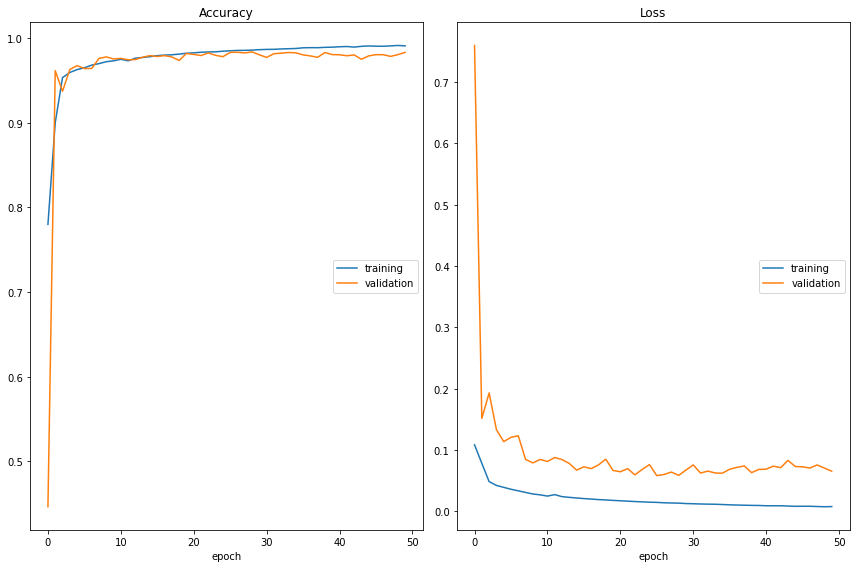

Accuracy
	training         	 (min:    0.780, max:    0.991, cur:    0.991)
	validation       	 (min:    0.447, max:    0.984, cur:    0.983)
Loss
	training         	 (min:    0.008, max:    0.109, cur:    0.008)
	validation       	 (min:    0.058, max:    0.760, cur:    0.066)
3985/3985 [==============================] - 44s 11ms/step - loss: 0.0079 - acc: 0.9908 - val_loss: 0.0656 - val_acc: 0.9831


In [37]:
history = model.fit(X_train_encoded_padded, y_train,
                    epochs=50,
                    validation_data=(X_test_encoded_padded, y_test),
                    class_weight=class_weight,
                    sample_weight=sample_weights_train,
                    callbacks=[PlotLossesKeras()])

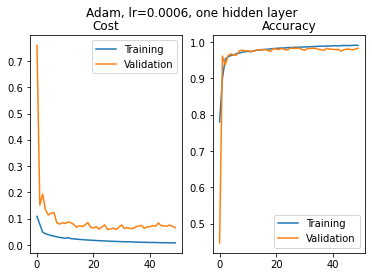

In [38]:
fig = plt.figure()
fig.suptitle("Adam, lr=0.0006, one hidden layer")

ax = fig.add_subplot(1,2,1)
ax.set_title('Cost')
ax.plot(history.history['loss'], label='Training')
ax.plot(history.history['val_loss'], label='Validation')
ax.legend()

ax = fig.add_subplot(1,2,2)
ax.set_title('Accuracy')
ax.plot(history.history['acc'], label='Training')
ax.plot(history.history['val_acc'], label='Validation')
ax.legend()

fig.show()

In [39]:
print(len(model.layers))
# Model built in evaluate
results = model.evaluate(X_test_encoded_padded, y_test)
print(results)

3
704/704 [==============================] - 5s 7ms/step - loss: 0.0656 - acc: 0.9831
[0.06563442200422287, 0.9830666780471802]


In [ ]:
print(X_test[0])

www.sportsillustrated.cnn.com/vault/gallery/featured/GAL1166954/12/19/


In [41]:
# Testing some handcrafted examples to see how it does.
print("\nPhishing ULR examples:")
predict_url("frgcxtmjawefgrthdcusge.dab")
predict_url("evilmadeupurl.phish")
predict_url("evil.madeupurl.phish")

print("\nSafe URL examples:")
predict_url("www.google.com")
predict_url("mail.google.com/mail/u/0/?tab=rm&ogbl#inbox")
predict_url("www.stackoverflow.com/questions/73354863/valueerror-input-0-of-layer-lstm-6-is-incompatible-with-the-layer")
predict_url("www.sportsillustrated.cnn.com/vault/gallery/featured/GAL1166954/12/19/")
predict_url("colab.research.google.com")
predict_url("00-gayrettepe-t3-8---00-gayrettepe-xrs-t2-1.statik.turktelekom.com.tr")


Phishing ULR examples:
1/1 [==============================] - 0s 51ms/step
Prediction on url: frgcxtmjawefgrthdcusge.dab 0.99975806
1/1 [==============================] - 0s 41ms/step
Prediction on url: evilmadeupurl.phish 0.9999733
1/1 [==============================] - 0s 35ms/step
Prediction on url: evil.madeupurl.phish 0.99996257

Safe URL examples:
1/1 [==============================] - 0s 46ms/step
Prediction on url: www.google.com 0.0014380134
1/1 [==============================] - 0s 29ms/step
Prediction on url: mail.google.com/mail/u/0/?tab=rm&ogbl#inbox 0.9999988
1/1 [==============================] - 0s 18ms/step
Prediction on url: www.stackoverflow.com/questions/73354863/valueerror-input-0-of-layer-lstm-6-is-incompatible-with-the-layer 0.0011089267
1/1 [==============================] - 0s 17ms/step
Prediction on url: www.sportsillustrated.cnn.com/vault/gallery/featured/GAL1166954/12/19/ 0.0002816748
1/1 [==============================] - 0s 19ms/step
Prediction on url: co

704/704 [==============================] - 3s 5ms/step


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:138: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Best performance at threshold: 0.8233668341708543
704/704 [==============================] - 3s 5ms/step
Calculated 22500 predictions with a mean value of 0.3370459973812103
Evaluating using threshold 0.8233668341708543
Cut-off threshold: 0.8234
Evaluation counts: {'TN': 14898, 'FP': 106, 'FN': 238, 'TP': 7258}
+------------------+----------------+--------------------+
| Accuracy 98.471% | Predicted safe | Predicted phishing |
+------------------+----------------+--------------------+
|   Not phishing   |   TN: 14898    |      FP: 106       |
|                  |  NPV: 98.428%  |    FDR: 1.439%     |
|                  |  TNR: 99.294%  |    FPR: 0.706%     |
|   Is phishing    |    FN: 238     |      TP: 7258      |
|                  |  FOR: 1.572%   |    PPV: 98.561%    |
|                  |  FNR: 3.175%   |    TPR: 96.825%    |
+------------------+----------------+--------------------+

Examples for TN Bin range: 4.1041332e-08 - 0.1641549 , Num. Samples: 14602
                     

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  del sys.path[0]



Examples for TP Bin range: 0.824935 - 0.85994804 , Num. Samples: 19
                                                                                                                 input  ground truth  prediction
0                                                                                    www.virallagi26video.duckdns.org/             1    0.840694
1                                                                                                         m.hf305.com/             1    0.859061
2                                                                                     www.blackhorsetrails.co.za/h.php             1    0.857468
3                                                                  www.brooks-athlete.online/index.php?main_page=login             1    0.855886
4   www.google.com/url?q=https%3A%2F%2Fgoogledocivi.yolasite.com%2F&sa=D&sntz=1&usg=AFQjCNHQm96HVqAZlge9bjnNnjEvtrLsPA             1    0.843425
5                                                            

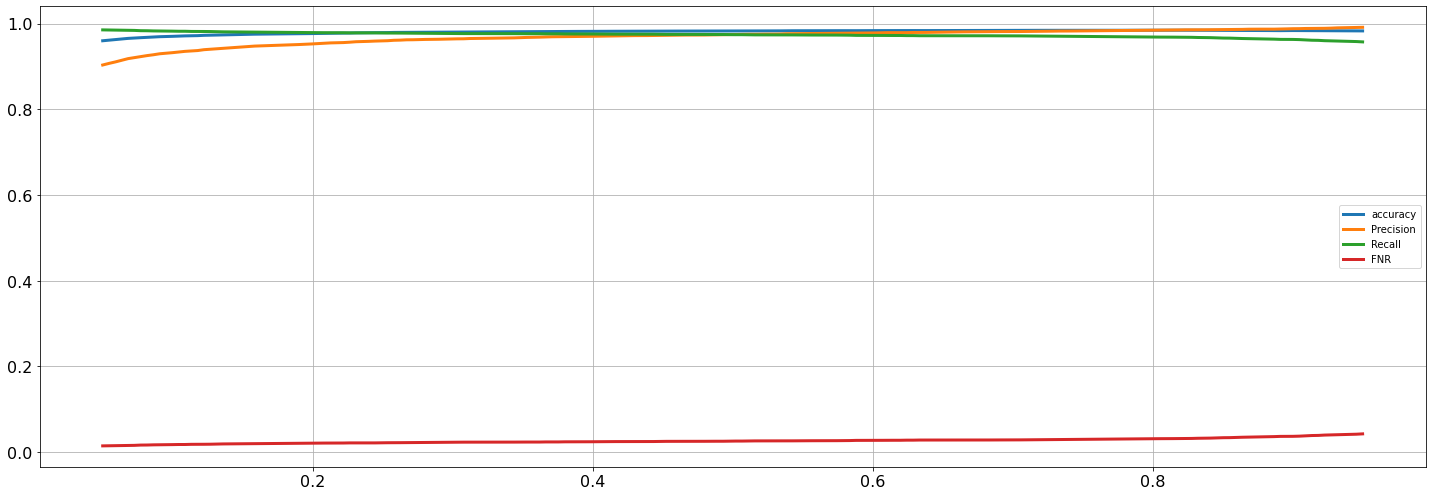

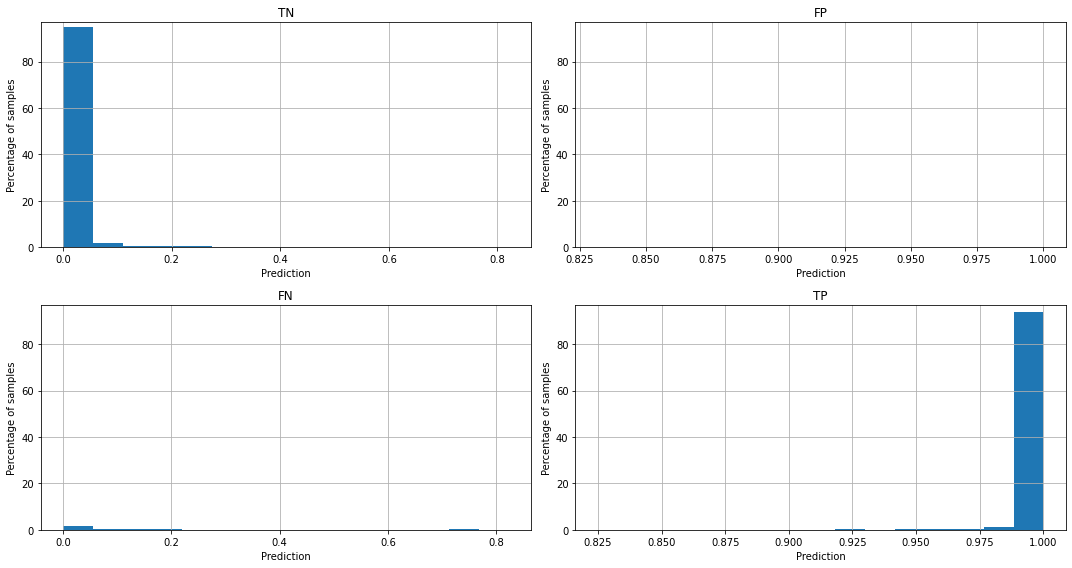

In [42]:
# Custom evaluate
best_threshold = threshold_evaluation_plotter(X_test_encoded_padded, y_test)
mean_prediction = evaluate_nn_model(X_test_encoded_padded, y_test, threshold=best_threshold)